* [refer to](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb)

#### ConvNet
* compositionality (= many layers) ; 신호 합성 
* locality + stationarity of images (= convolutions)
* invariance of object class to translations (= pooling)
  

In [1]:
import os 
import random 
import math 

import numpy as np 
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

from IPython import display  # (ref) https://financedata.github.io/posts/display-all-values-in-cell-jupyter-notebook.html

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
# ====================================== #
# function to count number of parameters #
# ====================================== # 
""" 모델 파라미터 세는 방법; (ref) https://aigong.tistory.com/196
"""


def get_n_params(model):
    np=0
    for p in list(model.parameters()):  # (ref) https://easy-going-programming.tistory.com/11
        np += p.nelement()   # (ref) https://pytorch.org/docs/stable/generated/torch.Tensor.nelement.html#
    return np

In [4]:
# Set style (needs to be in a new cell)
set_default()

In [5]:
# %% 02. 프로세스 장비 설정 
gpu_no = 0  # gpu_number 
device = torch.device( f'cuda:{gpu_no}' if torch.cuda.is_available() else 'cpu')

In [6]:
# ============ #
# Reproducible #
# ============ # 
""" 
    (ref) https://hoya012.github.io/blog/reproducible_pytorch/
    (ref) https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not
"""
seed = 12345

os.environ["PYTHONHASHSEED"] = str(seed)    # set PYTHONHASHSEED env var at fixed value
                                            # (ref) https://dacon.io/codeshare/2363
                                            # (ref) https://www.programmersought.com/article/16615747131/
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Load the Dataset (MNIST)
* We can use some PyTorch ```DataLoader utilities``` for this. 
* This will download, shuffle, normalize data and arrange it in batches.

In [7]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader( datasets.MNIST('../data', train=True, download=True,
                                                            transform=transforms.Compose([  transforms.ToTensor(),
                                                                                            transforms.Normalize((0.1307,), (0.3081,))], # mean & std to each channel 
                                                                                        )
                                                            ),
                                            batch_size=64, shuffle=True
                                        )

test_loader = torch.utils.data.DataLoader(  datasets.MNIST('../data', train=False, 
                                            transform=transforms.Compose([  transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,))
                                                                        ])
                                                            ),
                                            batch_size=1000, shuffle=True
                                        )

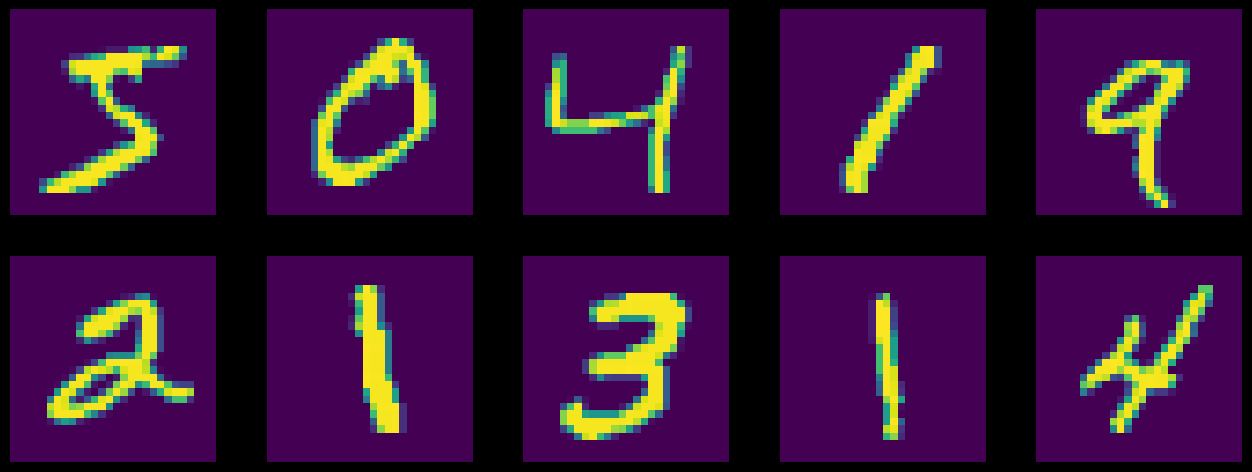

In [8]:
# show some images
plt.figure(figsize=(16, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)

    image, _ = train_loader.dataset.__getitem__(i)  # (ref) https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/03_01_dataloader.html
                                                    # (ref) https://jinmay.github.io/2019/11/26/python/python-instance-slice/

    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

## Create the model classes 

In [9]:
# ========================= #
# FC-layer, or Linear layer # 
# ========================= #

class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size

        self.network = nn.Sequential(   nn.Linear(input_size, n_hidden), # (ref) https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
                                        nn.ReLU(), # (ref) https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
                                        nn.Linear(n_hidden, n_hidden), 
                                        nn.ReLU(), 
                                        nn.Linear(n_hidden, output_size), 
                                        nn.LogSoftmax(dim=1),   # (ref) https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html
                                                                # (ref) https://discuss.pytorch.org/t/dimension-for-logsoftmax/49042
                                                                # (ref) http://www.gisdeveloper.co.kr/?p=8668
                                                                # (ref) https://doheejin.github.io/pytorch/2021/03/22/pytorch-softmax.html
                                    )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)



# ========================= #
#  Convolution neural nets  # 
# ========================= #
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)  # (ref) https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)  # (ref) https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(-1, self.n_feature*4*4)  # reshape; (ref) https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string 
* Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [10]:
accuracy_list = []



# ========================= #
#        Train-loop         # 
# ========================= #
def train(epoch, model, optimizer, perm=torch.arange(0, 784).long()):

    model.train()  # (ref) https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        # (ref) https://pytorch.org/docs/stable/tensors.html
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        
        output = model(data)
        loss = F.nll_loss(output, target)  # (ref) https://pytorch.org/docs/1.9.0/generated/torch.nn.functional.nll_loss.html
        
        
        optimizer.zero_grad()  # set zero grad 
        loss.backward()        # backprop 
        optimizer.step()       # update 

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')




# ========================= #
#    Validation-loop        # 
# ========================= #
def test(model, perm=torch.arange(0, 784).long()):

    model.eval()

    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)

        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss    

        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 

        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()  # torch.eq() ; (ref) https://pytorch.org/docs/stable/generated/torch.eq.html

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

## Train a small fully-connected network 

In [11]:
n_hidden = 8 # number of hidden units 

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)

optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)  # (ref) https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

print(f'Number of parameters: {get_n_params(model_fnn)}')

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.318726
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.737037
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.117471
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.817028
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.597250
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.548916
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.676296
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.480408
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.464082
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.282212

Test set: Average loss: 0.4410, Accuracy: 8642/10000 (86%)



## Train a ConvNet with t he same number of parameters 

In [12]:
# Training settings 

n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters: {get_n_params(model_cnn)}')

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.282189
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.919333
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.439680
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.317455
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.120710
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.290049
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.183263
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.234289
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.164227
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.220795

Test set: Average loss: 0.1409, Accuracy: 9563/10000 (96%)



The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images¶
* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

## What happens if the assumptions are no longer true?

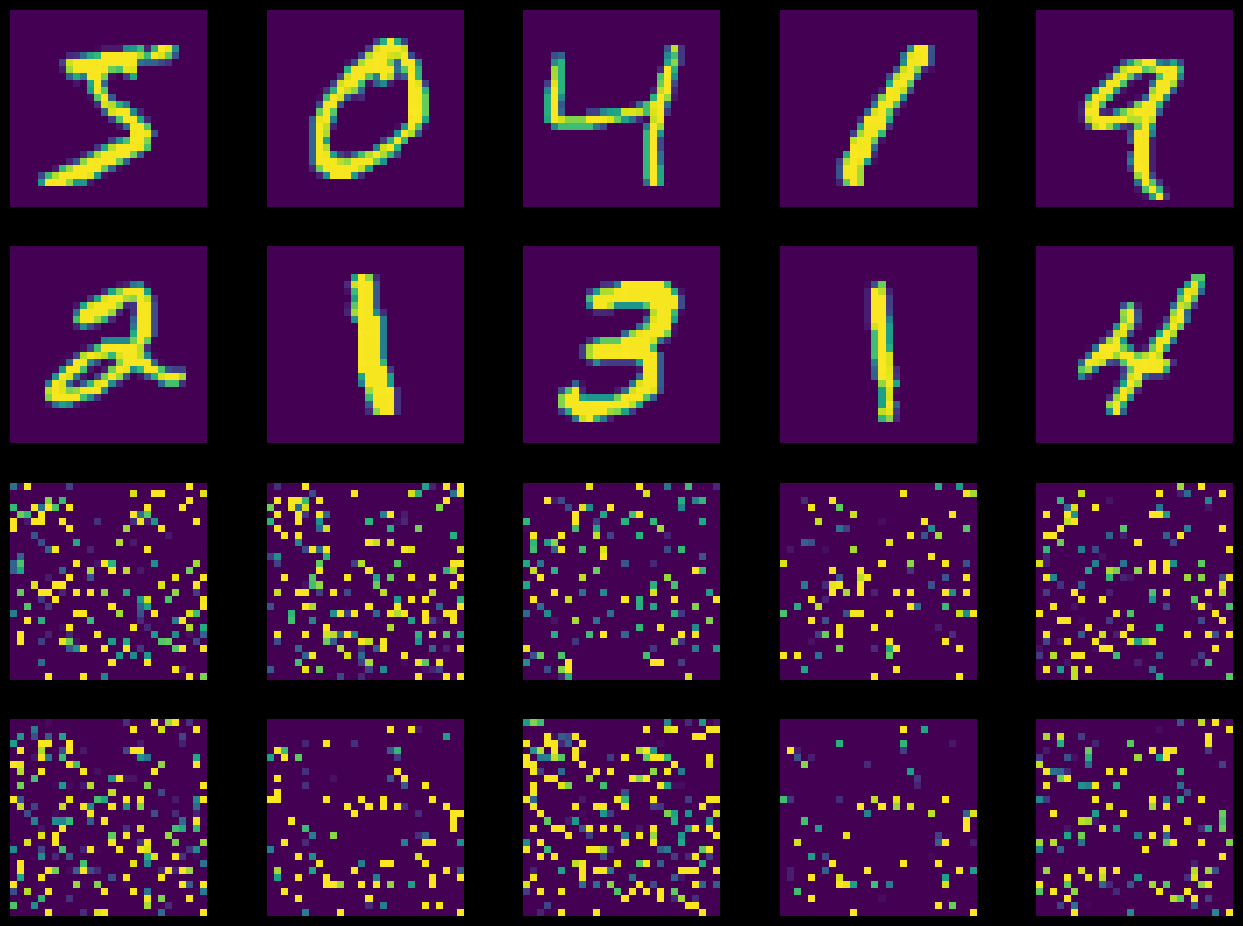

In [13]:
perm = torch.randperm(784) # (ref) https://pytorch.org/docs/stable/generated/torch.randperm.html


plt.figure(figsize=(16, 12))

for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)

    # permute pixels (= shuffling the pixels)
    image_perm = image.view(-1, 28*28).clone()   # deep copy; (ref) https://pytorch.org/docs/stable/generated/torch.Tensor.clone.html
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())  # squeeze; (ref) https://pytorch.org/docs/stable/generated/torch.squeeze.html
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

## Fully-Connected with Permuted Pixels (= shuffling the pixels)

In [14]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)

optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

print(f'Number of parameters: {get_n_params(model_fnn)}')

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.278417
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.591499
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.884850
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.798525
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.637789
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.716728
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.416959
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.330202
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.537174
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.348840

Test set: Average loss: 0.4048, Accuracy: 8812/10000 (88%)



## ConvNet with permuted pixels

In [15]:
# Training settings 

n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

print(f'Number of parameters: {get_n_params(model_cnn)}')

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306628
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.280486
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.176830
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.855720
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.460062
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.126368
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.833494
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.747493
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.722626
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.857951

Test set: Average loss: 0.5786, Accuracy: 8178/10000 (82%)



### (★★★) The ConvNet's ```performance drops``` when we permute the pixels, but the Fully-Connected Network's performance stays the same
* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

Text(0.5, 1.0, 'Performance comparison')

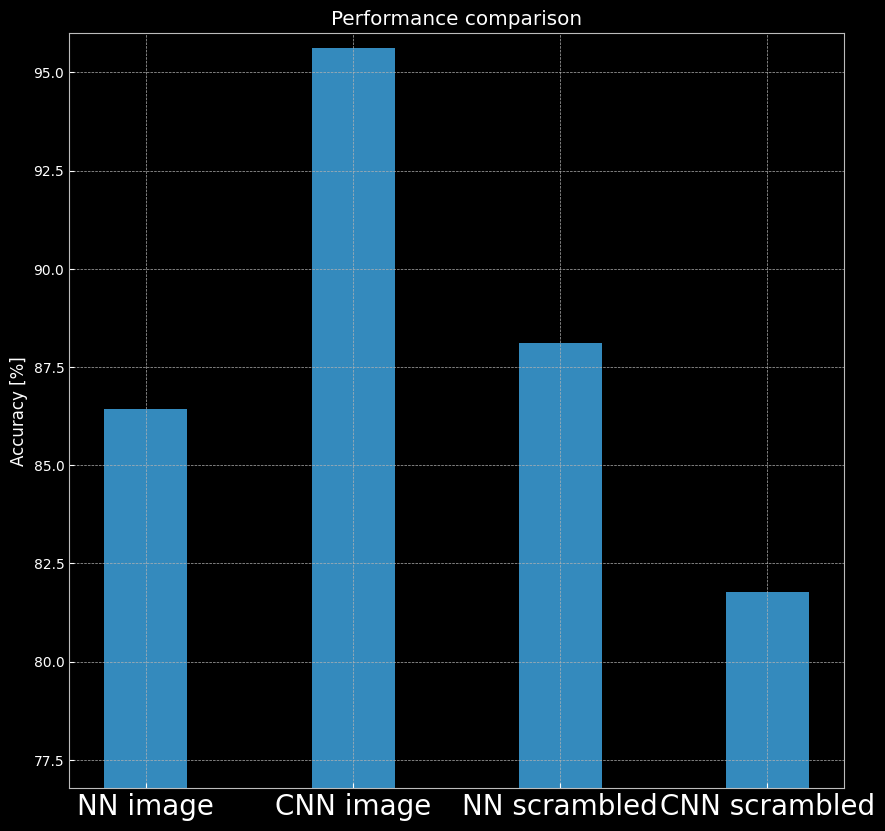

In [16]:
plt.bar(('NN image', 'CNN image', 'NN scrambled', 'CNN scrambled'),
        accuracy_list, width=0.4
        )

plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.title('Performance comparison')

## Checking Model Parameters 

In [17]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'doub

In [18]:

print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'conv1', 'conv2', 'c